In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [59]:
device = "mps"
block_size = 100
test_size = 1500
batch_size = 64

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [60]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=44, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.sigmoid(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 95.9 K
-------------------------------
95.9 K    Trainable params
0         Non-trainable params
95.9 K    Total params
0.384     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 38.66it/s]And nowBAenP9[[y[öF[9FY/WWY/mY33338:N/JaYö

<QQ,,=Ra."YaRYY3337Y3Y333Y3
Epoch 3: 100%|██████████| 118/118 [00:02<00:00, 49.01it/s, loss=1.6, v_num=109, test_loss=1.700] And now homean dow."

"Those or a bears took wonkian come taken. Ad it 
Epoch 6: 100%|██████████| 118/118 [00:02<00:00, 48.28it/s, loss=1.52, v_num=109, test_loss=1.550]And nowed the took anger and I will tell by to me.

The dess along to a
Epoch 7: 100%|██████████| 118/118 [00:02<00:00, 48.58it/s, loss=1.51, v_num=109, test_loss=1.520]And now is found who wearted any were a could not of them show wait.

"
Epoch 8: 100%|██████████| 118/118 [00:02<00:00, 47.63it/s, loss=1.48, v_num=109, test_loss=1.500]And now trave you to he can got a pony were saw, steed to them."

W the
Epoch 13: 100%|██████████| 118/118 [00:02<00:00, 48.07it/s, loss=1.45, v_num=109, test_loss=1.450]And now, and and then a boy, the cened.

"There shut it, it. I am could
Epoch 1

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 118/118 [00:02<00:00, 42.57it/s, loss=1.4, v_num=109, test_loss=1.440]


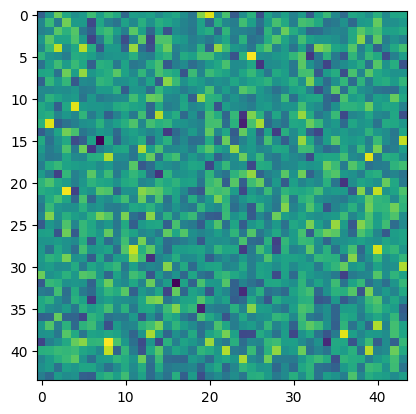

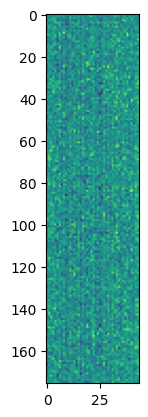

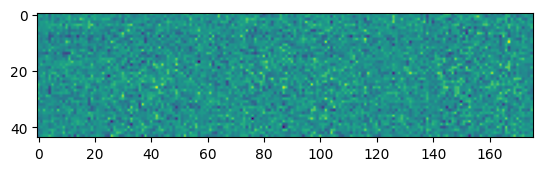

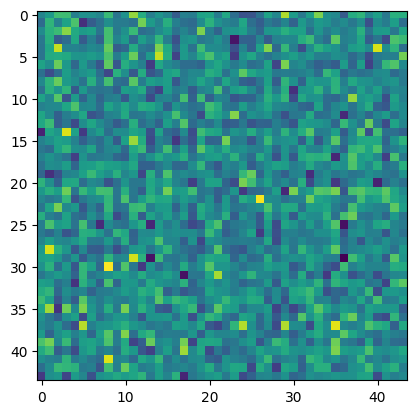

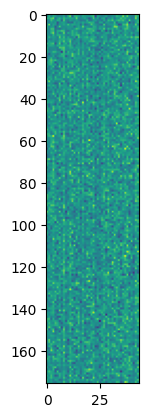

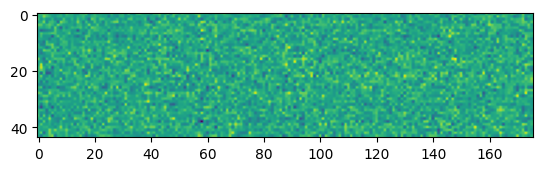

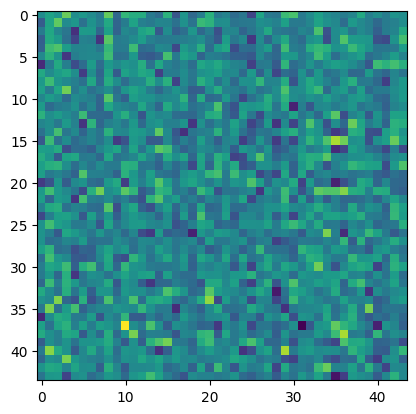

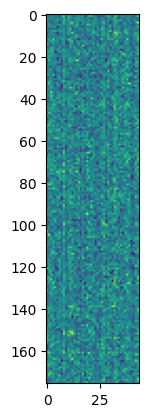

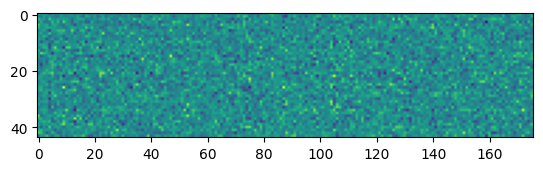

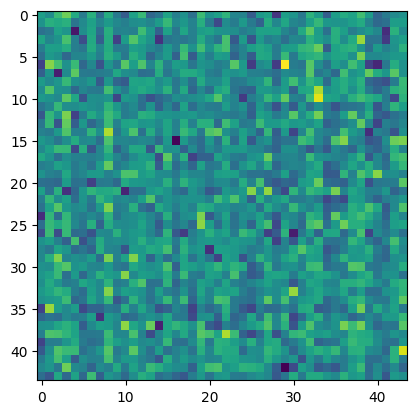

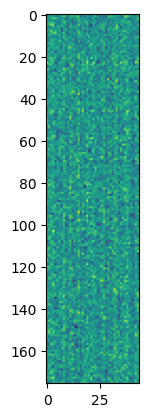

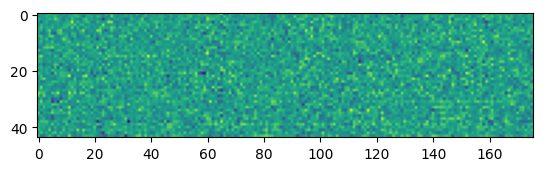

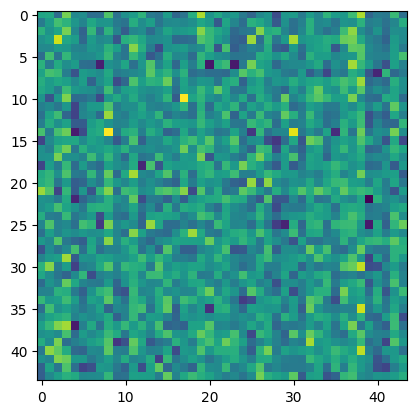

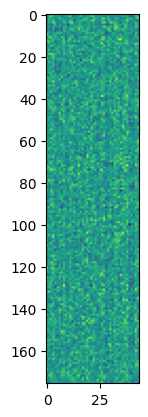

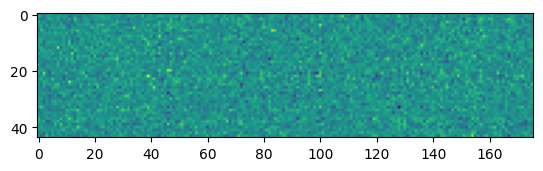

In [61]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [62]:
print(model.generate("O God, O God!", 650))

O God, O God!" and pumple when in throw that at legs were that for was and the part into they make umn would not her way and there work told her things, she was home. And what yu, and they feel that I have that the tall again, who was not come to see on the toys had tleaths and and she diand one.

"Yes, and sister as I has glad out to go to his heard.

"Oh, we'll go to go down!"

So they had story, when he wound far of her anothers camp talked here. Ha, how they could looked, "I went down to make-been founds and lifty."

"Well, for why though the toys were tangering to can far of state held murdishside thought when their began too, and they spear they wel
